In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


class PINN(tf.keras.Model):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross–Pitaevskii equation.

    This network consists of 3 hidden layers with 'tanh' activation and an output layer
    that produces a single solution value `u(x)` without activation.

    Attributes
    ----------
    hidden_layers : list
        List of three dense layers with 32 units each and 'tanh' activation.
    output_layer : Dense layer
        Output layer with a single unit and no activation.

    Methods
    -------
    call(x):
        Performs a forward pass through the network for input x.
    """

    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(32, activation='tanh') for _ in range(3)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)


def rayleigh_quotient(model, x, eta, u, u_x):
    """
    Computes the Rayleigh quotient for the given model output to estimate the eigenvalue.

    Parameters
    ----------
    model : PINN
        The PINN model used for approximating the solution to the Gross–Pitaevskii equation.
    x : tf.Tensor
        Input tensor for which to compute the Rayleigh quotient.
    eta : float
        Nonlinearity parameter for the Gross–Pitaevskii equation.
    u : tf.Tensor
        Model output for the given input.
    u_x : tf.Tensor
        First derivative of the model output with respect to the input.

    Returns
    -------
    tf.Tensor
        The Rayleigh quotient, an estimate of the eigenvalue.
    """
    numerator = tf.reduce_mean(tf.square(u_x) + 0.5 * eta * tf.square(tf.square(u)))
    denominator = tf.reduce_mean(tf.square(u))
    return numerator / denominator


def compute_loss(model, x, eta, B, N):
    """
    Optimized computation of the total loss, including Rayleigh quotient, boundary,
    normalization, and PDE residual losses.

    Parameters
    ----------
    model : PINN
        The PINN model for solving the Gross–Pitaevskii equation.
    x : tf.Tensor
        Input tensor for computing the loss.
    eta : float
        Nonlinearity parameter for the Gross–Pitaevskii equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.

    Returns
    -------
    tuple of tf.Tensor
        The total loss and Rayleigh quotient loss.
    """
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        u = model(x)   # Predict u(x)
        u_x = tape.gradient(u, x)  # Compute du/dx
    u_xx = tape.gradient(u_x, x)  # Compute d²u/dx²

    # Calculate the Rayleigh quotient and losses
    rayleigh_loss = rayleigh_quotient(model, x, eta, u, u_x)
    boundary_loss = tf.reduce_mean(tf.square(model(tf.constant([[0.0], [1.0]]))))
    norm_loss = tf.square(tf.reduce_mean(tf.square(u)) - 1.0)

    # Delete tape to free resources
    del tape

    # PDE residual: d²u/dx² + η * u^4 + λu = 0
    residual = u_xx + eta * tf.square(tf.square(u)) + rayleigh_loss * u
    pde_loss = tf.reduce_mean(tf.square(residual))

    # Total loss
    total_loss = rayleigh_loss + B * boundary_loss + N * norm_loss + pde_loss
    return total_loss, rayleigh_loss


def train_model(model, x_train, epochs, optimizer, eta, B, N):
    """
    Trains the PINN model to solve the 1D Gross–Pitaevskii equation.

    Parameters
    ----------
    model : PINN
        The PINN model to be trained.
    x_train : tf.Tensor
        Training data points in the domain [0, 1].
    epochs : int
        Number of training epochs.
    optimizer : tf.keras.optimizers.Optimizer
        Optimizer for training the model.
    eta : float
        Nonlinearity parameter for the Gross–Pitaevskii equation.
    B : float
        Weighting factor for the boundary loss.
    N : float
        Weighting factor for the normalization loss.

    """
    x_train_np = x_train.numpy()

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss, rayleigh_loss = compute_loss(model, x_train, eta, B, N)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 2000 == 0:
            u_pred = model(x_train).numpy()
            u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))

            plt.figure()
            plt.plot(x_train_np, u_pred, label=f'Predicted Solution (η ≈ {eta})')
            plt.plot(x_train_np, np.sin(np.pi * x_train_np), label='sin(πx) baseline')
            plt.title(f'Ground State Solution at Epoch {epoch}')
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.ylim([tf.reduce_min(u_pred).numpy() - 0.1, tf.reduce_max(u_pred).numpy() + 0.1])
            plt.grid(True)
            plt.legend()
            plt.show()
            plt.close()

            print(f'Epoch {epoch}: Loss = {loss.numpy():.5e}, Rayleigh Quotient λ = {rayleigh_loss.numpy():.5f}')

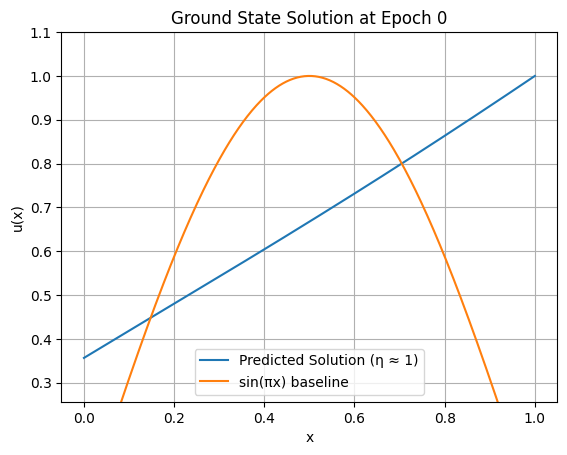

Epoch 0: Loss = 1.00602e+03, Rayleigh Quotient λ = 2.90037


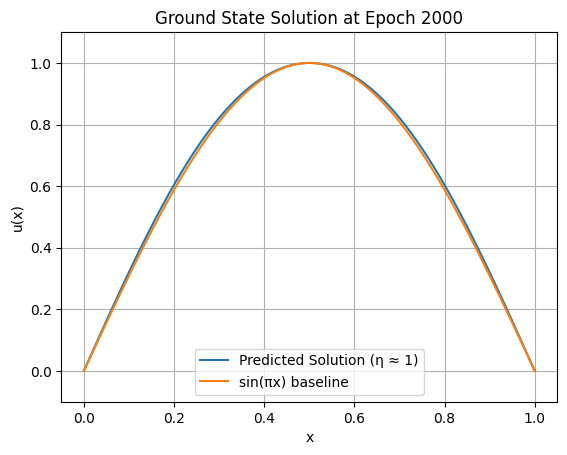

Epoch 2000: Loss = 1.18775e+01, Rayleigh Quotient λ = 10.65875


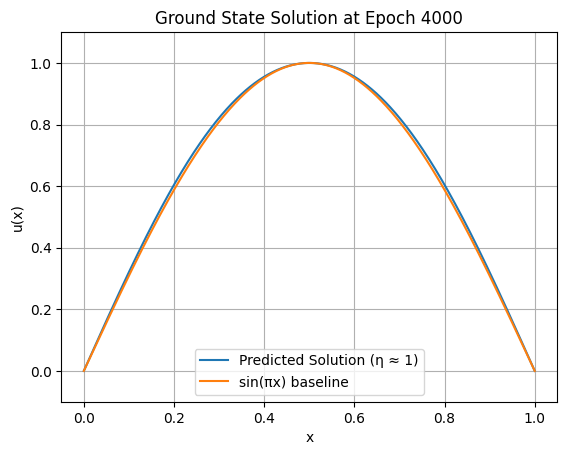

Epoch 4000: Loss = 1.18700e+01, Rayleigh Quotient λ = 10.65862


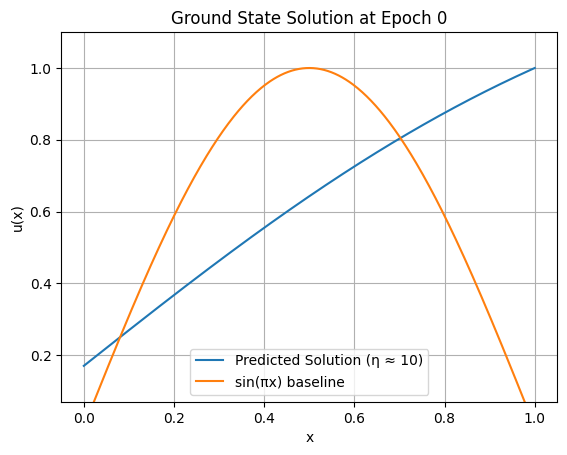

Epoch 0: Loss = 1.01067e+03, Rayleigh Quotient λ = 2.81445


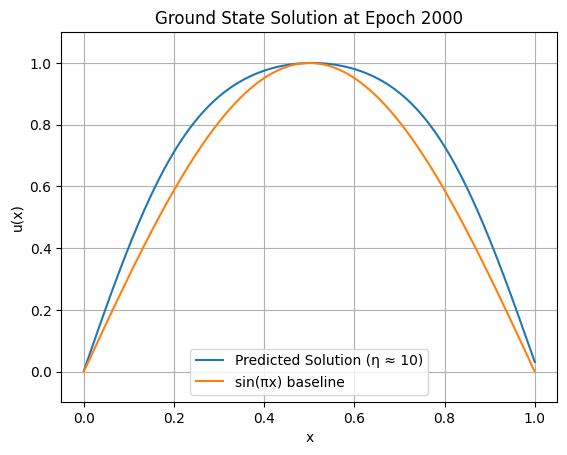

Epoch 2000: Loss = 9.25268e+01, Rayleigh Quotient λ = 17.13847


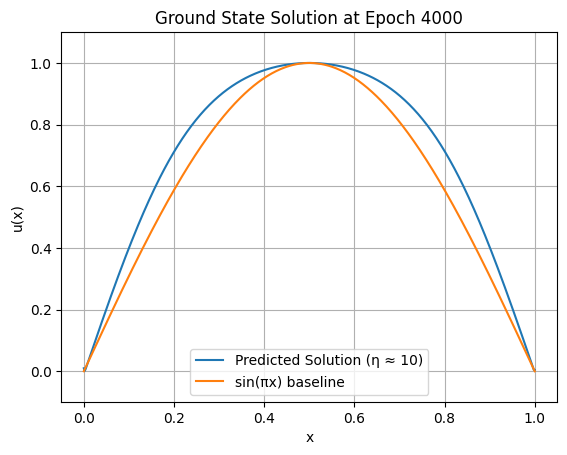

Epoch 4000: Loss = 8.20792e+01, Rayleigh Quotient λ = 16.78964


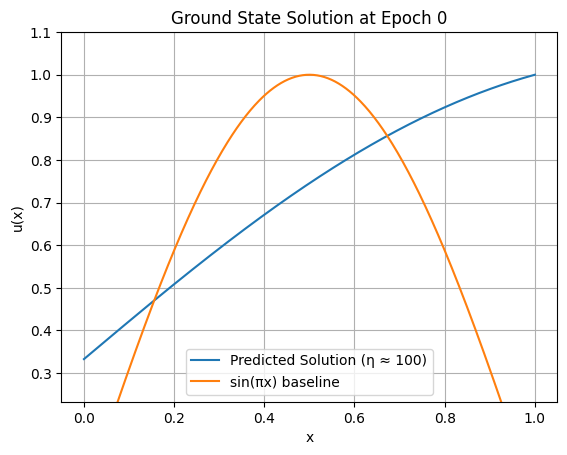

Epoch 0: Loss = 1.00647e+03, Rayleigh Quotient λ = 3.12979


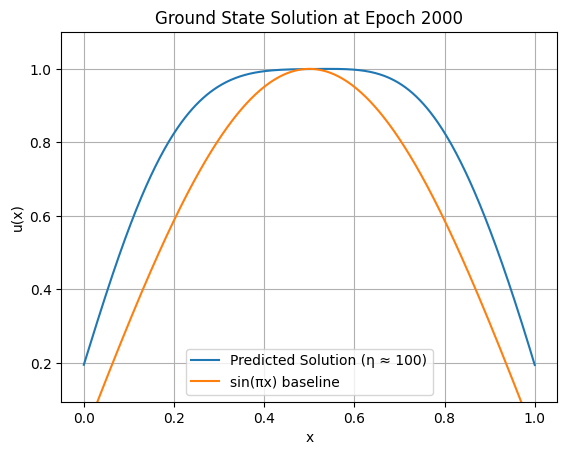

Epoch 2000: Loss = 7.95307e+02, Rayleigh Quotient λ = 17.26991


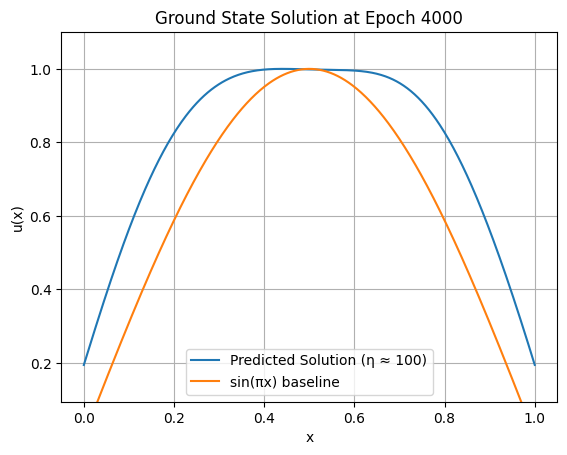

Epoch 4000: Loss = 7.95198e+02, Rayleigh Quotient λ = 17.28514


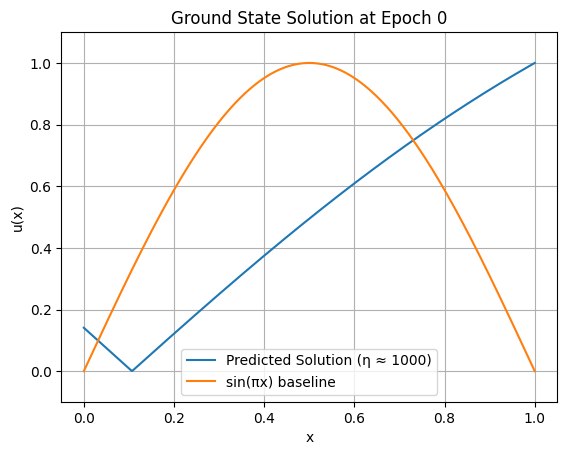

Epoch 0: Loss = 1.08209e+03, Rayleigh Quotient λ = 25.96173


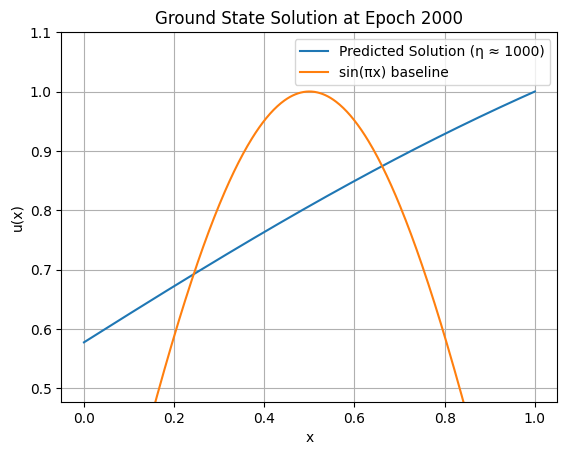

Epoch 2000: Loss = 1.01420e+03, Rayleigh Quotient λ = 11.59560


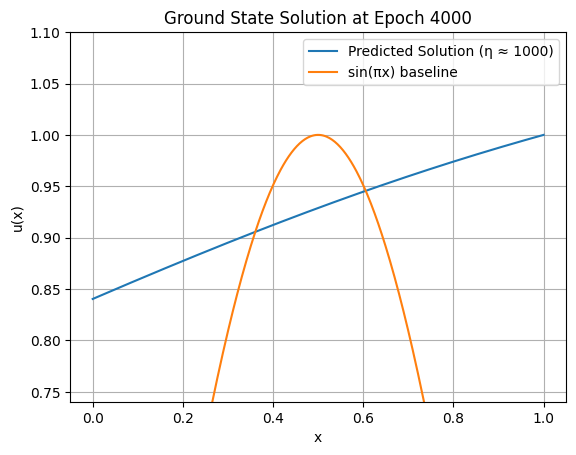

Epoch 4000: Loss = 1.00096e+03, Rayleigh Quotient λ = 0.96572


In [11]:
N_train = 500
x_train = tf.convert_to_tensor(np.linspace(0, 1, N_train).reshape(-1, 1), dtype=tf.float32)

models = [PINN() for _ in range(4)]
etas = [1, 10, 100, 1000]
Bs = [2000, 2000, 2000, 2000]
Ns = [1000, 1000, 1000, 1000]
epochs_list = [4001, 4001, 4001, 4001]

for model, eta, B, N, epochs in zip(models, etas, Bs, Ns, epochs_list):
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    train_model(model, x_train, epochs, optimizer, eta, B, N)

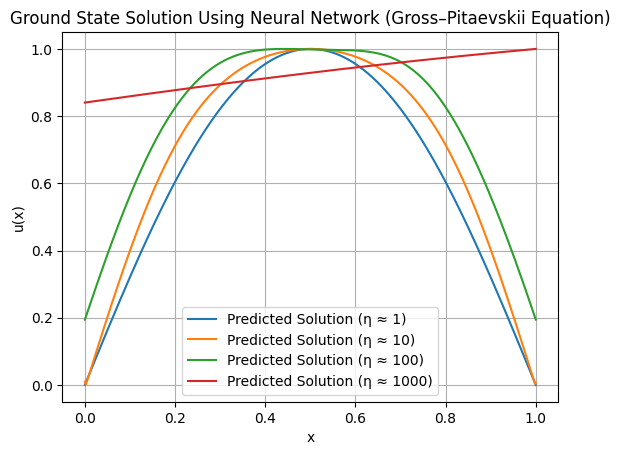

In [12]:
 # Final plot of the predicted solution
for model, eta in zip(models, etas):
    u_pred = model(x_train).numpy()
    u_pred = np.abs(u_pred) / np.max(np.abs(u_pred))
    plt.plot(x_train.numpy(), u_pred, label=f'Predicted Solution (η ≈ {eta})')

plt.title('Ground State Solution Using Neural Network (Gross–Pitaevskii Equation)')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()